# Определение перспективного тарифа для телеком-компании

* В этом проекте нам предстоит проанализировать два тарифа: "Смарт" и "Ультра" оператора связи "Мегалайн".
* Мы проанализируем данные об активности пользователей различных тарифов. 
* Посмотрим какими видами услуг пользуются клиенты разных тарифов. 
* Проверим гипотезы:
    * средняя выручка клиентов различных тарифов отличается
    * средняя выручка клиентов из Москвы отличается от клиентов из других городов

In [2]:
import pandas as pd
import numpy as np
# import scipy.stats as st
import matplotlib.pyplot as plt

In [7]:
df_calls = pd.read_csv('../datasets/calls.csv')
df_internet = pd.read_csv('../datasets/internet.csv', index_col=0)
df_messages = pd.read_csv('../datasets/messages.csv')
df_tariffs = pd.read_csv('../datasets/tariffs.csv')
df_users = pd.read_csv('../datasets/users.csv')

df_tariffs.rename(columns={"tariff_name":"tariff"}, inplace = True)

list_of_data = [df_calls, df_internet, df_messages, df_tariffs, df_users]

### Проверка данных на пропуски

In [20]:
df_users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


In [8]:
for data in list_of_data:
    data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   

**Из условий задания про колонку churn_date мы знаем: "если значение пропущено, то тариф ещё действовал на момент выгрузки данных". Значит все в порядке, пропусков нет, можем идти дальше**

### Приведите данные к нужным типам

In [ ]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])

#### Найдите и исправьте ошибки в данных, если они есть.
* Обнаружили 462 пропуска в колонке churn_date, однако по условию задачи это означает, что тариф все еще действует
* Все колонки, содаржащие информацию о дате, были приведены к соответствующему типу.
* Пропущенные звонки обозначены нулями, это не ошибка.
* Больше никаких ошибок не обнаружено

#### Посчитайте для каждого пользователя:

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [5]:
# Добавляем месяц в каждый датасет, где необходима группировка по месяцу. 

df_calls['month'] = df_calls['call_date'].astype('datetime64[M]')
df_messages['month'] = df_messages['message_date'].astype('datetime64[M]')
df_internet['month'] = df_internet['session_date'].astype('datetime64[M]')

In [6]:
# Округляем каждый звонок в бОльшую сторону, согласно условиям тарифа. 
df_calls['duration'] = df_calls['duration'].apply(np.ceil).astype(int)

# Группируем данные по пользователю и месяцу, считаем количество уникальных звонков и 
# суммируем длительность звонков по каждому месяцу.

calls_by_user = df_calls.groupby(['user_id', 'month']).agg({'id':'count','duration':'sum'}).reset_index()
calls_by_user.columns = ['user_id', 'month', 'calls_count', 'duration_sum']
calls_by_user

,user_id,month,calls_count,duration_sum
0,1000,2018-05-01,22,159
1,1000,2018-06-01,43,172
2,1000,2018-07-01,47,340
3,1000,2018-08-01,52,408
4,1000,2018-09-01,58,466
...,...,...,...,...
3169,1498,2018-10-01,41,247
3170,1499,2018-09-01,9,70
3171,1499,2018-10-01,68,449
3172,1499,2018-11-01,74,612


In [7]:
# Сгруппируем данные по пользователю и месяцу, посчитаем кол-во уникальных сообщений

messages_by_user = df_messages.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index()
messages_by_user.columns = ['user_id', 'month', 'messages_count']

messages_by_user

,user_id,month,messages_count
0,1000,2018-05-01,22
1,1000,2018-06-01,60
2,1000,2018-07-01,75
3,1000,2018-08-01,81
4,1000,2018-09-01,57
...,...,...,...
2712,1498,2018-10-01,42
2713,1499,2018-09-01,11
2714,1499,2018-10-01,48
2715,1499,2018-11-01,59


In [8]:
# Группируем по пользователю и месяцу, считаем количество уникальных сессий и суммируем трафик внутри месяца.

traffic_by_user = df_internet.groupby(['user_id', 'month']).agg({'id':'count', 'mb_used':'sum'}).reset_index()
traffic_by_user.columns = ['user_id','month','sessions_count','traffic_sum']

# Округляем использованный траффик в большую сторону, согласно условиям тарифа

traffic_by_user['traffic_sum'] = (traffic_by_user['traffic_sum']
                                  .apply(lambda x: np.ceil(x / 1024) ).astype(int))
# traffic_by_user

In [9]:
# Объединяем таблицы по колонке user_id

# Сначала добавляем информацию об использовании интернет траффика
df_merged = calls_by_user.merge(traffic_by_user, on=['user_id', 'month'], how='outer')
# Теперь добавляем информацию о смс сообщениях
df_merged = df_merged.merge(messages_by_user, on=['user_id', 'month'], how='outer')
# Добавляем информацию ою используемом тарифе
df_merged = df_merged.merge(df_users[['user_id','tariff']], on='user_id')

In [10]:
# На всякий случай проверяем, нет ли в выборке пользователей, которые не использовали ни один из видов услуг (сообщения, звонки, интернет)
(df_merged[
    df_merged[['calls_count', 'sessions_count', 'messages_count']].isna().all(axis=1)])

,user_id,month,calls_count,duration_sum,sessions_count,traffic_sum,messages_count,tariff


**Пусто, значит каждый юзер пользовался одним из видов услуг, хотябы один раз**

---

In [11]:
df_merged

,user_id,month,calls_count,duration_sum,sessions_count,traffic_sum,messages_count,tariff
0,1000,2018-05-01,22.0,159.0,5.0,3.0,22.0,ultra
1,1000,2018-06-01,43.0,172.0,49.0,23.0,60.0,ultra
2,1000,2018-07-01,47.0,340.0,29.0,14.0,75.0,ultra
3,1000,2018-08-01,52.0,408.0,29.0,14.0,81.0,ultra
4,1000,2018-09-01,58.0,466.0,27.0,15.0,57.0,ultra
...,...,...,...,...,...,...,...,...
3209,1489,2018-08-01,NaN,NaN,34.0,11.0,17.0,smart
3210,1489,2018-09-01,NaN,NaN,63.0,17.0,32.0,smart
3211,1489,2018-10-01,NaN,NaN,63.0,20.0,21.0,smart
3212,1489,2018-11-01,NaN,NaN,55.0,18.0,20.0,smart


**В получившейся таблице появились пропущенные значения, поскольку Nan иммет тип float, значения таких столбцов изменились на числа с плавающей точкой. Поскольку отсутствующее значение говорит о том, что юзер не использовал данный вид услуги, заменим такие значения на "0" и приведём к типу int**

In [12]:
# Заменяем пропуски на 0 и приводим к типу int. 
df_merged[df_merged.drop(columns='tariff').columns] = df_merged.drop(columns='tariff').fillna(0).astype(int)
# df_merged

#### Посчитайте помесячную выручку с каждого пользователя

In [13]:
def payment(fact, plan, tax):
    if fact <= plan:
        return 0
    else :
        return (fact - plan) * tax
    
def revenue(row):
    tariff = row['tariff']
    calls_duration = row['duration_sum']
    minutes_included = row['minutes_included']
    rub_per_minute = row['rub_per_minute']
    messages_count = row['messages_count']
    messages_included = row['messages_included']
    rub_per_messages = row['rub_per_message']
    internet_month = row['traffic_sum']
    gb_per_month_included = row['mb_per_month_included'] / 1024
    rub_per_gb = row['rub_per_gb']
    rub_monthly_fee = row['rub_monthly_fee']
    

    calls_payment = payment(calls_duration, minutes_included, rub_per_minute)
    messages_payment = payment(messages_count, messages_included, rub_per_messages)
    internet_payment = payment(internet_month, gb_per_month_included, rub_per_gb)
    
    return calls_payment + messages_payment + internet_payment + rub_monthly_fee

In [14]:
df_merged['user_month_revenue'] = df_merged.merge(df_tariffs, on='tariff').apply(revenue, axis=1)


### Проанализируйте данные
Опишите поведение клиентов оператора, исходя из выборки. Скольо требуется пользователям каждого тарифа в месяц?
* Сколько минут разговора, 
* сколько сообщений 
* какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 


* Посчитайте среднее количество
* дисперсию 
* стандартное отклонение. 
* Постройте гистограммы. 
* Опишите распределения.

In [16]:
df_smart = df_merged.query("tariff == 'smart'")
df_ultra = df_merged.query("tariff == 'ultra'")

In [17]:
display(df_smart.describe())
df_ultra.describe()

,user_id,month,calls_count,duration_sum,sessions_count,traffic_sum,messages_count,user_month_revenue
count,2229.000000,2.229000e+03,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,1246.506505,1.534005e+18,58.463437,417.934948,50.039928,16.328847,33.384029,1518.634814
std,146.119496,7.695338e+15,25.939858,190.313730,17.369098,5.747061,28.227876,794.311980
min,1001.000000,1.514765e+18,0.000000,0.000000,0.000000,0.000000,0.000000,550.000000
25%,1121.000000,1.527811e+18,40.000000,282.000000,40.000000,13.000000,10.000000,750.000000
50%,1239.000000,1.535760e+18,60.000000,422.000000,51.000000,17.000000,28.000000,1673.000000
75%,1376.000000,1.541030e+18,76.000000,545.000000,61.000000,20.000000,51.000000,1950.000000
max,1499.000000,1.543622e+18,198.000000,1435.000000,118.000000,38.000000,143.000000,6770.000000


,user_id,month,calls_count,duration_sum,sessions_count,traffic_sum,messages_count,user_month_revenue
count,985.000000,9.850000e+02,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,1263.094416,1.533750e+18,73.392893,526.623350,38.433503,19.494416,49.363452,1552.704569
std,140.694908,7.570598e+15,43.916853,317.606098,19.623227,9.853511,47.804457,807.001042
min,1000.000000,1.514765e+18,0.000000,0.000000,0.000000,0.000000,0.000000,550.000000
25%,1143.000000,1.527811e+18,41.000000,284.000000,24.000000,12.000000,6.000000,750.000000
50%,1277.000000,1.535760e+18,74.000000,518.000000,38.000000,19.000000,38.000000,1634.000000
75%,1381.000000,1.541030e+18,104.000000,752.000000,52.000000,27.000000,79.000000,1950.000000
max,1495.000000,1.543622e+18,244.000000,1673.000000,97.000000,49.000000,224.000000,5672.000000


In [18]:
def hist_compare(data_1:pd.DataFrame, data_2:pd.DataFrame, col_to_compare:str, describe=True):
    data_1[col_to_compare].plot(kind='hist', density=True, alpha=0.5)
    data_2[col_to_compare].plot(kind='hist', alpha=.5, grid=True, density=True,figsize=(15,7))
    plt.legend([data_1['tariff'].iloc[0], data_2['tariff'].iloc[0]]);

    if describe:
        display(df_merged.groupby('tariff')[col_to_compare].describe().T)
        

tariff,smart,ultra
count,2229.000000,985.000000
mean,417.934948,526.623350
std,190.313730,317.606098
min,0.000000,0.000000
25%,282.000000,284.000000
50%,422.000000,518.000000
75%,545.000000,752.000000
max,1435.000000,1673.000000


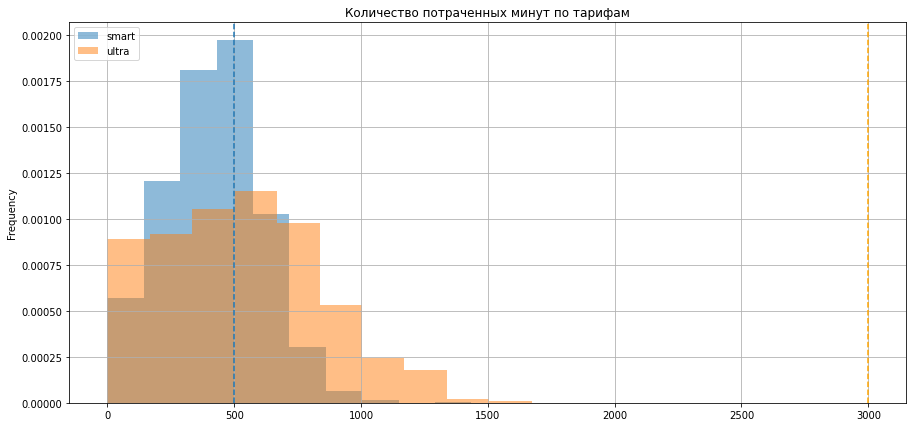

In [19]:
hist_compare(df_smart, df_ultra, 'duration_sum')
plt.axvline(500, linestyle='--');
plt.axvline(3000, color='Orange', linestyle='--');
plt.title('Количество потраченных минут по тарифам');

In [20]:
# Посчитаем долю клиентов тарифа smart, превысивших лимит пакета минут

print(f'Доля клиентов тарифа smart, превысивших лмимит минут: \
{df_smart.query("duration_sum > 500").shape[0] / df_smart.shape[0]:.0%}')

Доля клиентов тарифа smart, превысивших лмимит минут: 34%


**Выводы**
* На графике выше линиями отмечены включенные в абонентскую плату кол-во минут. 
* Тариф smart значительно популярнее тарифа ultra.
* Хорошо видно, что пользователи обоих тарифов используют приблизительно одинаковое количество минут. 
* Однако пользователи тарифа ultra все же гворят в среднем больше, но никто из клиентов не использовал пакет полностью. 
* Пользователи тарифа smart превышают лимит минут в 34% случаев.
* Оба распределения близки к нормальному, однако имеют положительную скошенность. 

tariff,smart,ultra
count,2229.000000,985.000000
mean,33.384029,49.363452
std,28.227876,47.804457
min,0.000000,0.000000
25%,10.000000,6.000000
50%,28.000000,38.000000
75%,51.000000,79.000000
max,143.000000,224.000000


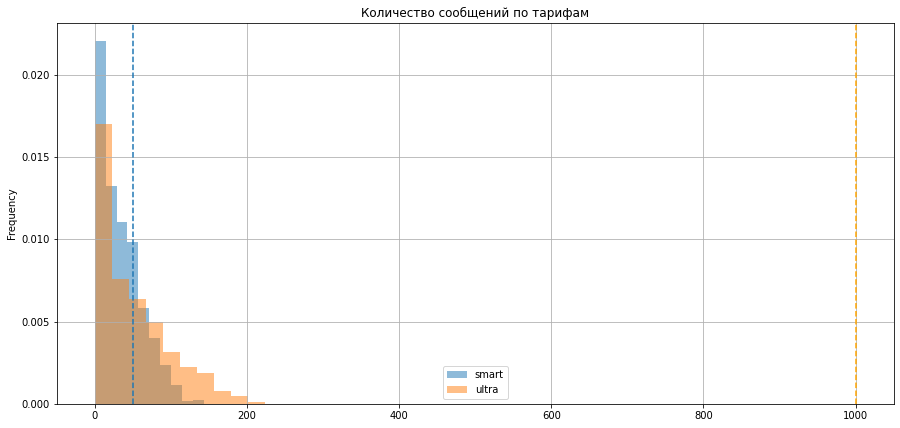

In [21]:
hist_compare(df_smart, df_ultra, 'messages_count')
plt.axvline(50, linestyle='--')
plt.axvline(1000, color='Orange', linestyle='--');
plt.title('Количество сообщений по тарифам');

In [22]:
print(f'Доля клиентов тарифа smart, превысивших лимит смс сообщений: \
    {df_smart.query("messages_count > 50").shape[0] / df_smart.shape[0]:.0%}')

Доля клиентов тарифа smart, превысивших лимит смс сообщений:     25%


**Похожая картина наблюдается и по смс сообщениям:**
* Скошенность графика влево на обоих тарифах, говрит о том, что клиенты крайне редко пользуются смс сообщениями. 
* 25 % клиентов тарифа smart превысили лимит сообщений
* На тарифе ultra в среднем немного больше отправляют смс сообщений.
* Оба тарифа имеют положительную скошенность. (Похоже на экспоненциальное распределение)

tariff,smart,ultra
count,2229.000000,985.000000
mean,16.328847,19.494416
std,5.747061,9.853511
min,0.000000,0.000000
25%,13.000000,12.000000
50%,17.000000,19.000000
75%,20.000000,27.000000
max,38.000000,49.000000


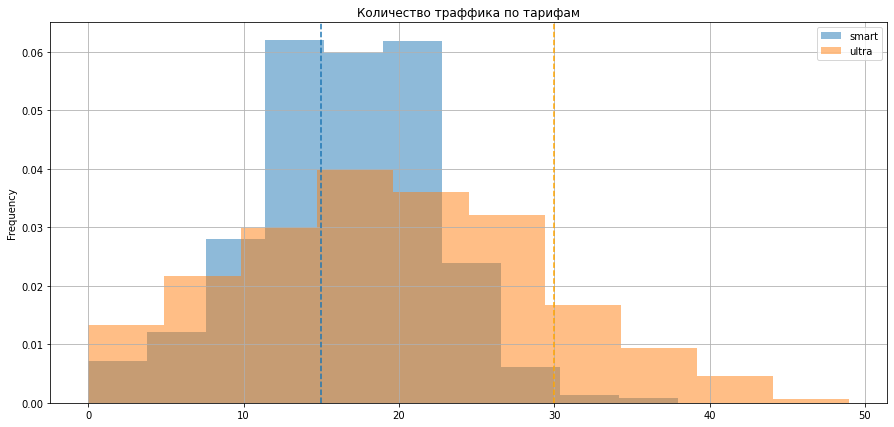

In [23]:
hist_compare(df_smart, df_ultra, 'traffic_sum')

plt.axvline(15, linestyle='--')
plt.axvline(30, color='Orange', linestyle='--');
plt.title('Количество траффика по тарифам');

In [24]:
print(f'Доля клиентов тарифа smart, превысивших лимит траффика: \
{df_smart.query("traffic_sum > 15").shape[0] / df_smart.shape[0]:.0%}')

print(f'Доля клиентов тарифа ultra, превысивших лимит траффика: \
{df_ultra.query("traffic_sum > 30").shape[0] / df_ultra.shape[0]:.0%}')

Доля клиентов тарифа smart, превысивших лимит траффика: 59%
Доля клиентов тарифа ultra, превысивших лимит траффика: 14%


**Выводы**
* Интернет является самой востребованной услугой связи для клиентов, вне зависимости от тарифа. 
* Включенного в пакет траффика недостаточно для клиентов обоих тарифов
* 59% клиентов тарифа smart и 14% тарифа ultra не укладываются в лимит траффика.
* Оба тарифа имеют нормальное распределение, без видимых скошенностей. 

**Клиенты все больше пользуются интернетом, возможно текущие лимиты устарели и имеет смысл их пересмотреть в сторону повышения. С одной стороны, каждый лишний гигабайт траффика приносит компании прибыль, однако это может стать серьезным поводом недовольства клиента, т.к. он скорее всего расчитывает укладываться в ежемесячную плату, или близкое к ней значение. А недовольный клиент может уйти к конкуренту. Для телекомов важнейшей метрикой является лояльность клиента.**

In [25]:
pivot_list = ['duration_sum', 'messages_count', 'traffic_sum', 'user_month_revenue']
for column in pivot_list:
    display(df_merged.groupby('tariff').agg({column:['mean','var','std']}))

duration_sum                           
               mean            var         std
tariff                                        
smart    417.934948   36219.315784  190.313730
ultra    526.623350  100873.633397  317.606098

messages_count                        
                 mean          var        std
tariff                                       
smart       33.384029   796.812958  28.227876
ultra       49.363452  2285.266143  47.804457

traffic_sum                     
              mean        var       std
tariff                                 
smart    16.328847  33.028705  5.747061
ultra    19.494416  97.091686  9.853511

user_month_revenue                           
                     mean            var         std
tariff                                              
smart         1518.634814  630931.520978  794.311980
ultra         1552.704569  651250.681940  807.001042

### Проверьте гипотезы


#### средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
**Нулевая гипотеза $H_0$ будет такова: Средняя выручка пользователелей тарифа "Ультра" и "Смарт" равны друг другу.**

**Альтернативная гипотеза $H_1$: Средняя выручка пользователей тарифа "Ультра" и "Смарт не равны друг ругу.**

In [35]:
# Задаем random_state для повторяемости результатов

# Сравниваем среднее двух выборок
rs=42

tariff_revenue_ttest = st.ttest_ind(df_smart['user_month_revenue'].sample(500, random_state=rs), 
                                  df_ultra['user_month_revenue'].sample(500, random_state=rs), 
                                random_state=rs)
# Задаем порог стат значимости 5%, 2%, 1%
alpha = [.05, .02, .01]

for a in alpha:
    if tariff_revenue_ttest.pvalue > a:
        print(f"Нулевая гипотеза принимается при уровне значимости  {a:.0%}, p-value = {tariff_revenue_ttest.pvalue}")
        
    else:
        print(f"Нулевая гипотеза отвергается при уровне значимости {a:.0%} p-value = {tariff_revenue_ttest.pvalue}")

        

Нулевая гипотеза принимается при уровне значимости  5%, p-value = 0.9662622251273598
Нулевая гипотеза принимается при уровне значимости  2%, p-value = 0.9662622251273598
Нулевая гипотеза принимается при уровне значимости  1%, p-value = 0.9662622251273598


**Принимаем нулевую гипотезу при уровне значимости 5%**

---

#### средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Нулевая гипотеза $H_0$: Средняя выручка пользователей Москвы равна выручке пользователей из других регионов**

**Альтернативная гипотеза $H_1$: Средняя выручка пользователей Москвы отличается от выручки пользователей из других городов**

In [29]:
# Делаем срезы согласно условию. 
msk_sbs = df_merged.merge(df_users[['city', 'user_id']], on='user_id').query("city == 'Москва'")
not_msk_sbs = df_merged.merge(df_users[['city', 'user_id']], on='user_id').query("city != 'Москва'")

In [30]:
city_revenue_ttest = st.ttest_ind(msk_sbs['user_month_revenue'].sample(500, random_state=rs),
                                 not_msk_sbs['user_month_revenue'].sample(500, random_state=rs),
                                 random_state=rs)


# Значение порогов alpha указывали выше, обратимся к ним еще раз
for a in alpha:
    if city_revenue_ttest.pvalue > a:
        print(f"Нулевая гипотеза принимается. alpha = {a:.0%}, p-value = {city_revenue_ttest.pvalue}")
    else:
        print(f"Нулевая гипотеза отвергается. alpha = {a:.0%} p-value = {city_revenue_ttest.pvalue}")

Нулевая гипотеза принимается. alpha = 5%, p-value = 0.42020373306012104
Нулевая гипотеза принимается. alpha = 2%, p-value = 0.42020373306012104
Нулевая гипотеза принимается. alpha = 1%, p-value = 0.42020373306012104


**При различных порогах alpha нулевая гипотеза принимается. Средняя выручка пользователей из Москвы не отличается от выручки пользователей других городов.**

#### Поясните:
* как вы формулировали нулевую и альтернативную гипотезы;
* какой критерий использовали для проверки гипотез и почему.

1. Нулевая гипотеза всегда формулируется так, чтобы использовать знак равенства, альтернативная гипотеза противоречит нулевой, может быть односторонней (отличается в большую или меньшую сторону), или односторонней (не равно нулевой гипотезе).
2. Поскольку четко заданного критерия p-value не существует, есть лишь общепринятый порог в 5%, однако для надежности все гипотезы я так же проверил на порогах 2% и 1%. 

### Вывод


1. Собранные данные имеют высокое качество, т.к. не содержат пропусов и ошибок
2. Клиенты обоих тарифов в среднем приносят компании одинаковое количество выручки, несмотря на значительные различия в абонентской плате.
3. Треть клиентов тарифа smart превышают свой ежемесячный лимит минут.
4. Ни один клиент тарифа ultra из выборки не превысил свой лимит минут. 
5. Клиенты обоих тарифов активно пользуются интернетом и превышают ежемесячный лимит на тарифе smart в 59% случаев и на тарифе ultra в 14 % случаев. **Стоит обратить на это вниамние, т.к. большинство клиентов тарифа smart тратят на связь больше, чем рассчитывают (исходя из ежемесячного платежа). Это снижает лояльность таких клиентов, может привести к их оттоку.** Возможно стоит расширить лимит траффика для повышения лояльности пользователей. 
6. Пользователи тарифа ultra превышают лимит смс сообщений в 25% случаев, по графику хорошо видно, что большинство пользователей тарифа отправляют крайне мало смс сообщений. 
7. Клиенты тарифа ultra имеют большой запас по лимиту смс сообщений и почти никогда его не используют. 
8. Гипотеза **средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются** отвергнута при уровне значимости 5%. 
9. Гипотеза **Средняя выручка пользователей Москвы отличается от выручки пользователей из других городов** отвергнута при уровне значимости 5%. 